# Fully saturated TWFE の解釈

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

figsize=(10, 5)

In [39]:
path = '../../data/processed/fully_saturated/homo.csv'
homo_beta_df = pd.read_csv(path)
# path = '../../data/processed/fully_saturated/hetero.csv'
# hetero_beta_df = pd.read_csv(path)
path = '../../data/processed/df_filtered.xlsx'
df = pd.read_excel(path)

In [40]:
df = df.rename(columns={'island_names': '島名'})

In [82]:
class FullySaturatedPlotter():
    def __init__(self, data=None, trace=None, beta_df=None):
        self.data = data
        self.trace = trace
        self.beta_df = beta_df

    def get_beta_df(self, trace):
        beta_df = az.summary(trace, var_names=['beta'], hdi_prob=0.95)
        # 正規表現でbridge_yearとtime_since_treatmentを抽出
        pattern = r'beta\[(\d+),\s*(-?\d+)\]'
        extracted = beta_df.index.str.extract(pattern)
        extracted.index = beta_df.index
        beta_df['bridge_year'] = extracted[0].astype(int)
        beta_df['time_since_treatment'] = extracted[1].astype(int)
        beta_df

    def plot_treatment_effect(self, bridge_year, ax=None):
        beta_g = self.beta_df.query(f'bridge_year == {bridge_year}').sort_values('time_since_treatment')
        fig, ax = plt.subplots(figsize=figsize)
        sns.lineplot(data=beta_g, x='time_since_treatment', y='mean', color='black', marker='o', label='平均', ax=ax)
        ax.fill_between(
            x='time_since_treatment',
            y1='hdi_97.5%',
            y2='hdi_2.5%',
            data=beta_g,
            alpha=0.3,
            color='black',
            label='95%信用区間'
        )
        ax.axhline(0, color='black', ls=':')
        ax.axvline(0, color='black', ls=':')
        ax.set_title(f'介入: {bridge_year} 年')
        ax.set_xlabel('経過年数')
        ax.set_ylabel('係数')
        ax.legend()

    def plot_population(self, bridge_year, ax=None):
        df_g = self.data.query(f'bridge_year == {bridge_year}')
        print(df_g.island_ids.unique())
        fig, ax = plt.subplots(figsize=figsize)
        sns.lineplot(x='year', y='population', data=df_g, color='black', ax=ax)
        ax.axvline(0, color='black', ls=':')
        ax.set_title(f'介入: {bridge_year}')
        ax.set_xlabel('経過年数')
        ax.set_ylabel('人口')

    def plot_population_and_treatment_effect(self, bridge_year):
        fig, ax = plt.subplots(2, 1, figsize=(10, 6))
        fig.suptitle(f'介入: {bridge_year}年', fontsize=16, y=0.93)
        # fig.subplots_adjust(hspace=0.4)
        # 人口変化率のプロット
        df_g = self.data.query(f'bridge_year == {bridge_year}')
        # num_obs = df_g.island_ids.nunique()
        sns.lineplot(
            x='year',
            y='pop_rate_of_change',
            data=df_g,
            color='black',
            marker='o',
            ax=ax[0],
            hue='島名',
            palette=['black'],
        )

        # 年平均のプロット
        year_df = pd.DataFrame()
        year_df['year_mean'] = self.data.groupby('year')['log_pop'].mean()
        min_year = df_g.year.min()
        year_df = year_df.query(f'year >= {min_year}')
        year_df['year_mean_diff'] = year_df.year_mean.diff()
        year_df.fillna(0, inplace=True)
        year_df['year_mean_cumsum'] = year_df['year_mean_diff'].cumsum()
        year_df['year_mean_change_rate'] = 100 * (np.exp(year_df['year_mean_cumsum']) - 1)
        sns.lineplot(data=year_df, x=year_df.index, y='year_mean_change_rate', ax=ax[0], color='black', marker='o', label='年平均', ls='--')
        # 装飾
        ax[0].axvline(bridge_year, color='black', ls=':', label='介入年')
        ax[0].set_title('')
        ax[0].set_ylabel('人口変化率 (%)')
        ax[0].set_xlabel('')
        ax[0].legend()

        # 係数のプロット
        beta_g = self.beta_df.query(f'bridge_year == {bridge_year}').sort_values('time_since_treatment')
        sns.lineplot(
            data=beta_g,
            x='time_since_treatment',
            y='mean',
            color='black',
            marker='o',
            # label='事後期待値',
            ax=ax[1]
        )
        ax[1].fill_between(
            x='time_since_treatment',
            y1='hdi_97.5%',
            y2='hdi_2.5%',
            data=beta_g,
            alpha=0.3,
            color='black',
            # label='95%信用区間'
        )
        ax[1].axhline(0, color='black', ls=':')
        ax[1].axvline(0, color='black', ls=':')
        ax[1].set_title('')
        ax[1].set_xlabel('経過年数')
        ax[1].set_ylabel('係数')
        # ax[1].legend()

        filepath = f'../../docs/figures/fully_saturated_twfe/{bridge_year}.png'
        fig.savefig(filepath, bbox_inches='tight')

<Axes: xlabel='year', ylabel='year_mean_change_rate'>

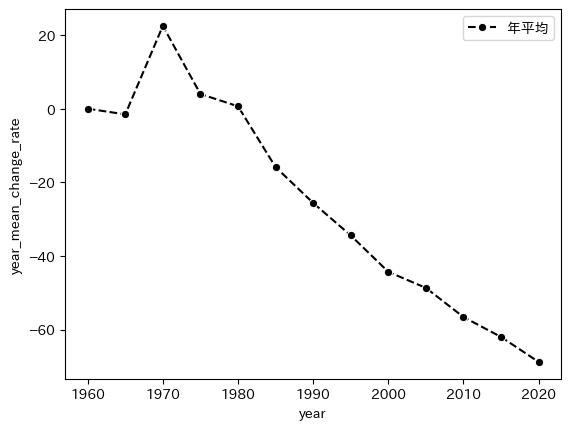

In [76]:
bridge_year = 1965

df_g = df.query(f'bridge_year == {bridge_year}')

year_df = pd.DataFrame()
year_df['year_mean'] = df.groupby('year')['log_pop'].mean()
min_year = df_g.year.min()
year_df = year_df.query(f'year >= {min_year}')
year_df['year_mean_diff'] = year_df.year_mean.diff()
year_df.fillna(0, inplace=True)
year_df['year_mean_cumsum'] = year_df['year_mean_diff'].cumsum()
year_df['year_mean_change_rate'] = 100 * (np.exp(year_df['year_mean_cumsum']) - 1)

sns.lineplot(data=year_df, x=year_df.index, y='year_mean_change_rate', color='black', marker='o', label='年平均', ls='--')

## 不均一分散

/tmp/ipykernel_2800/381798496.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=figsize)


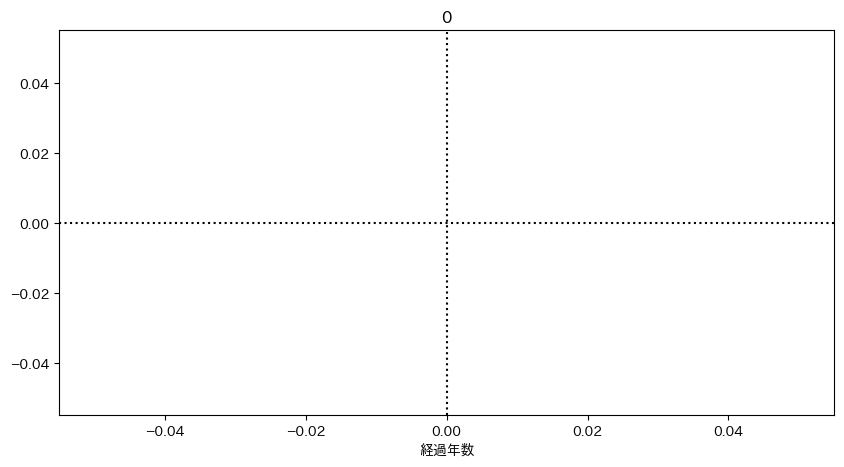

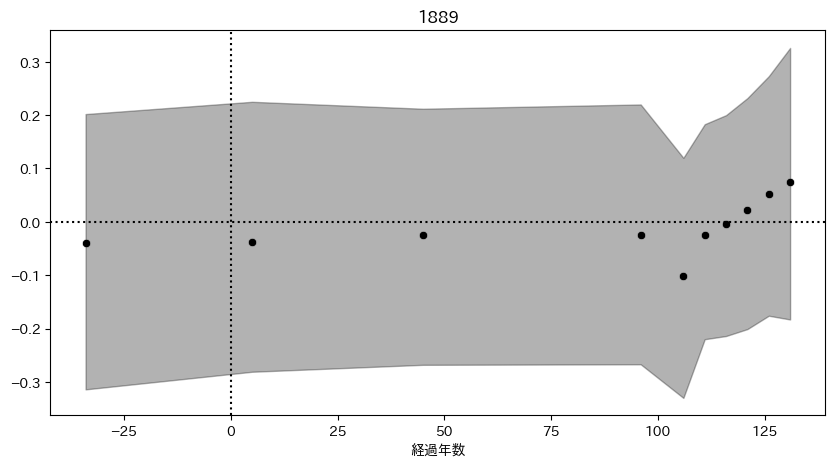

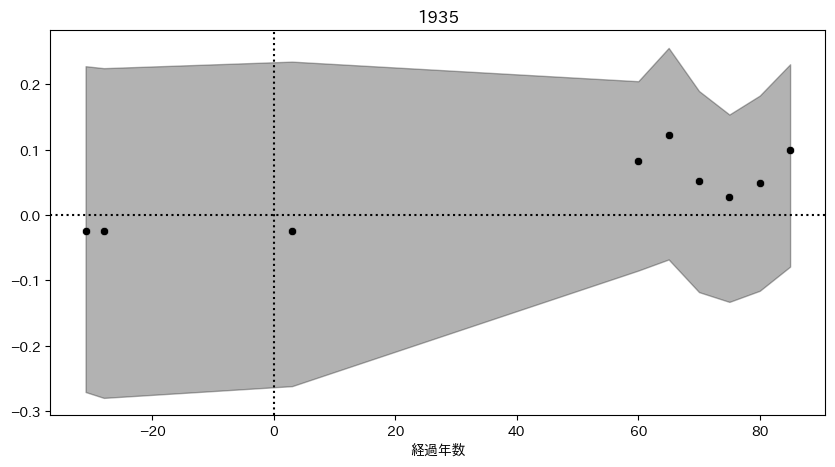

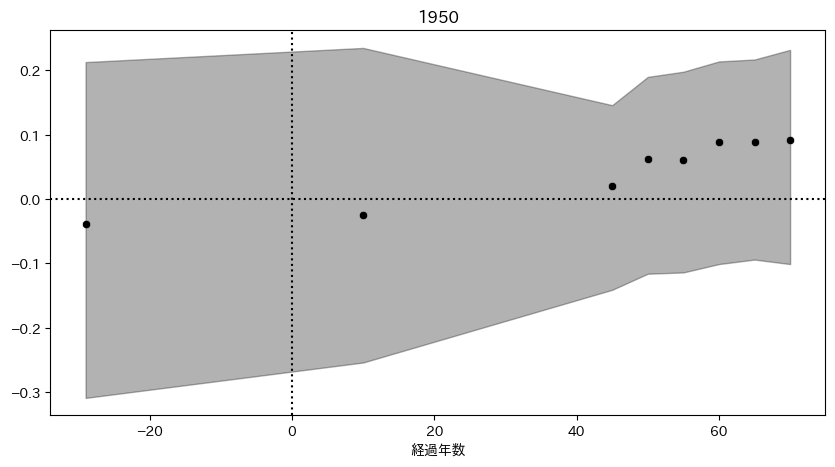

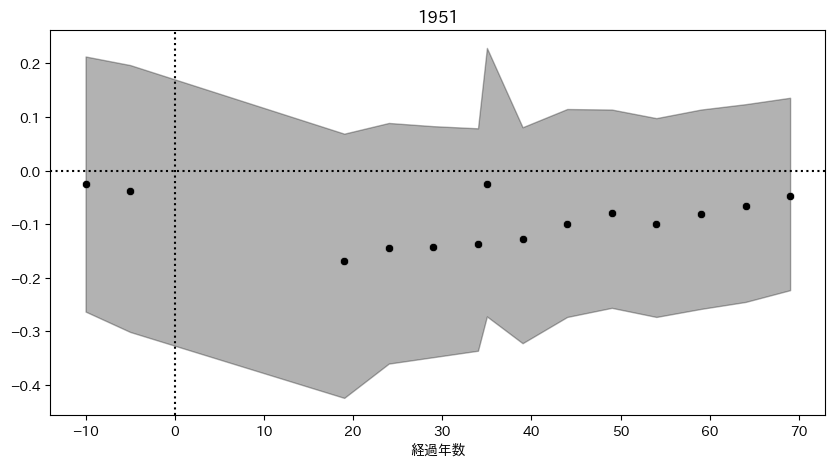

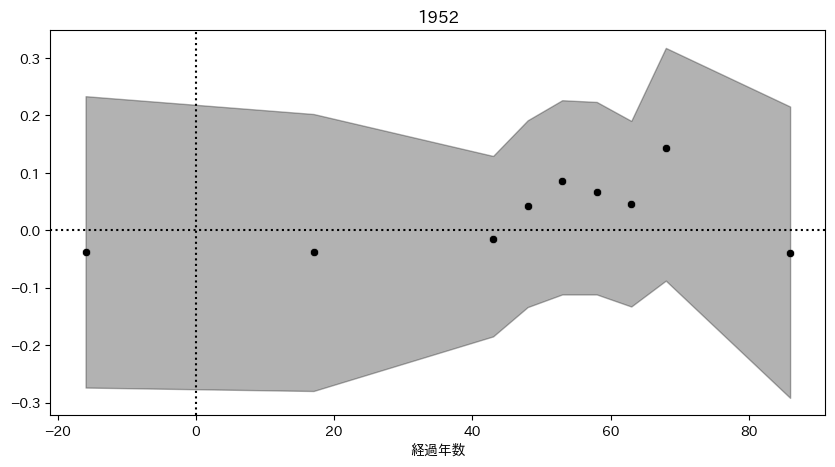

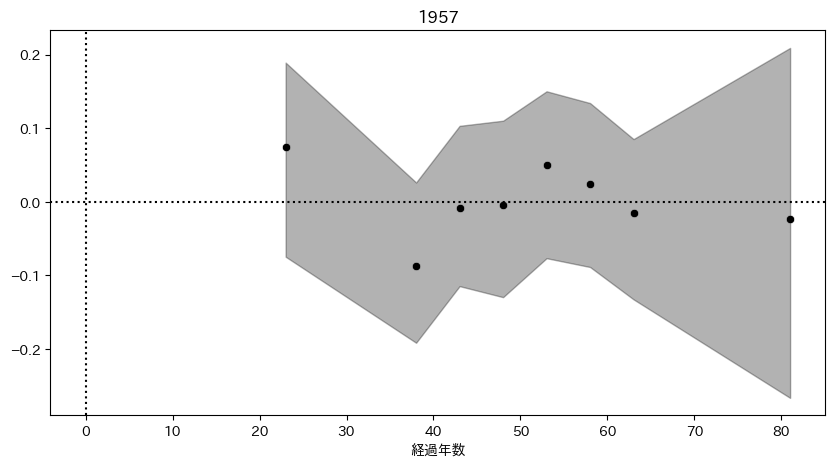

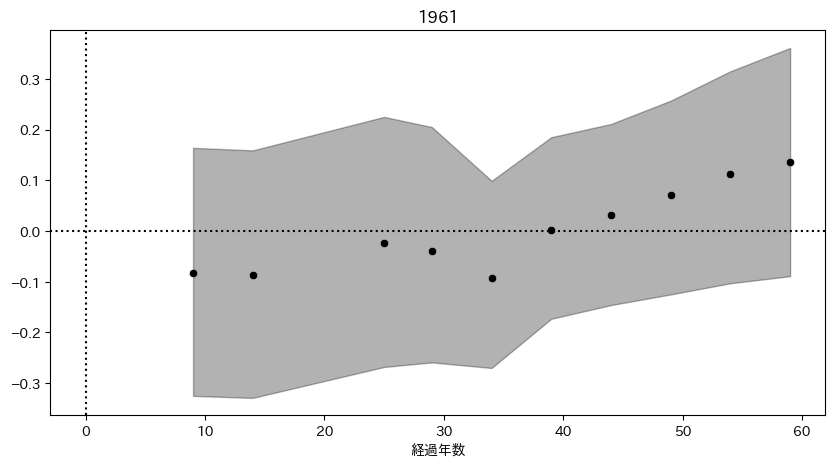

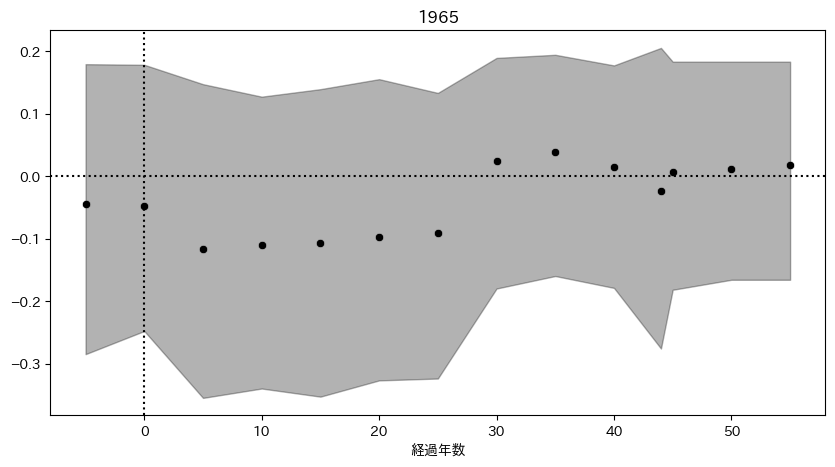

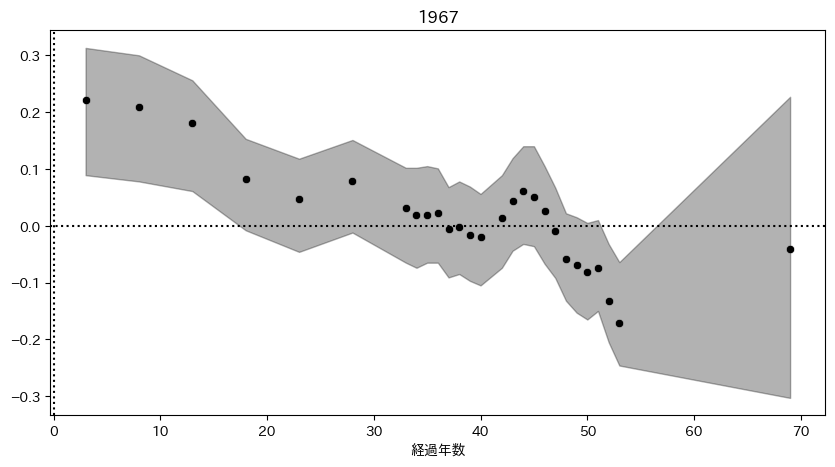

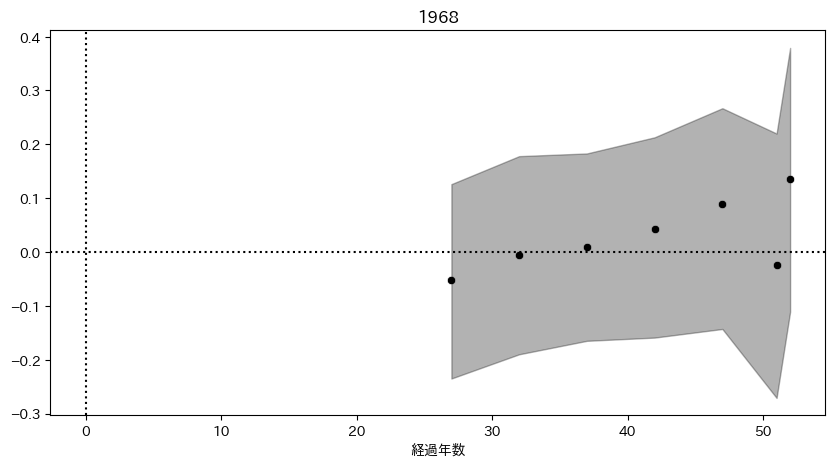

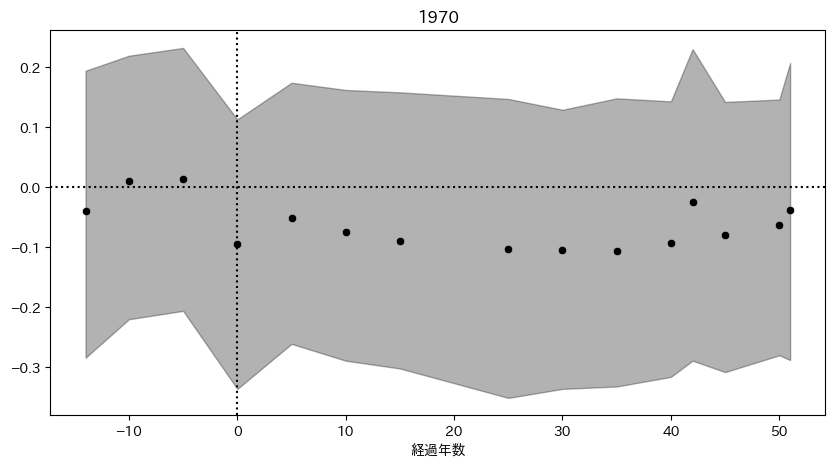

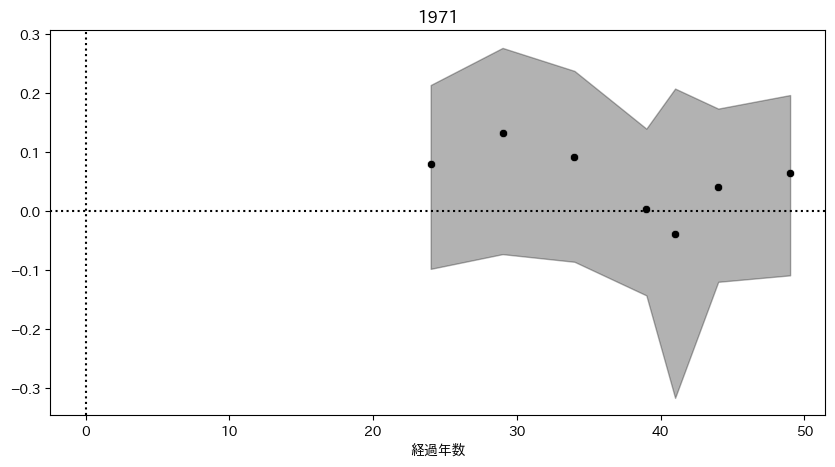

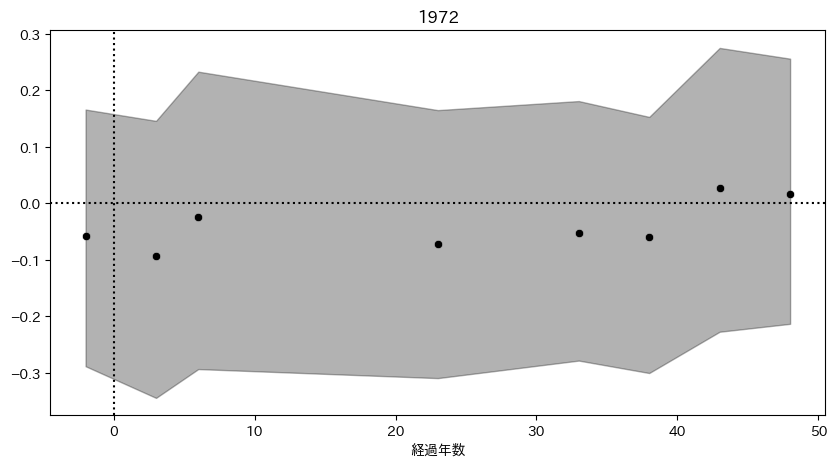

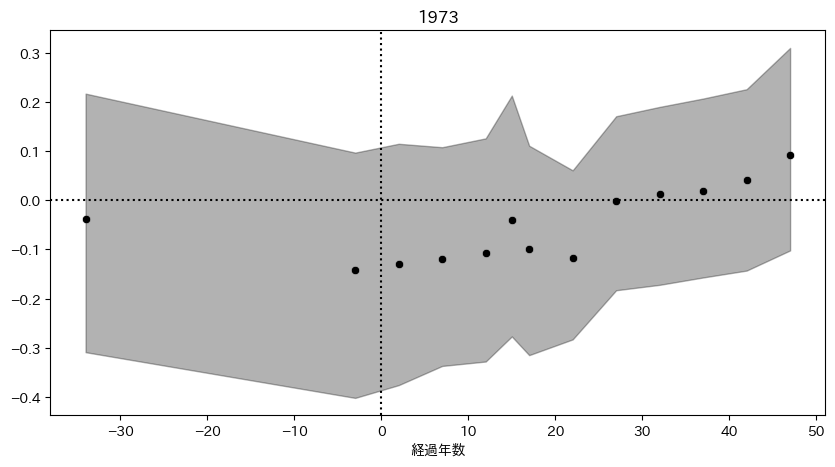

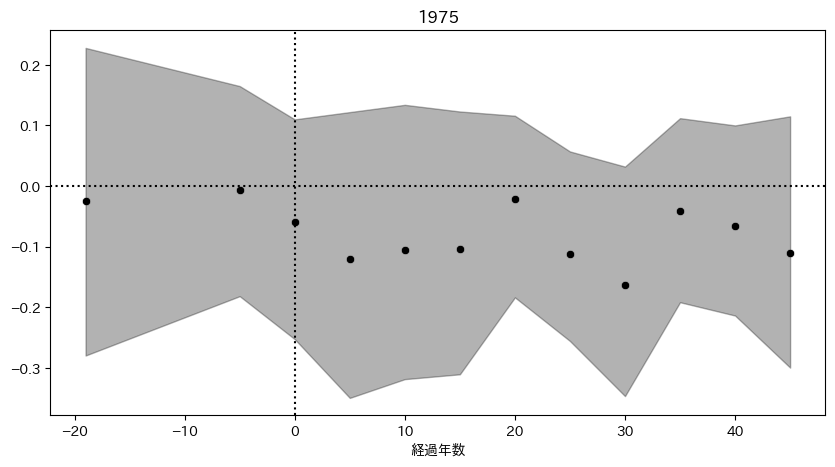

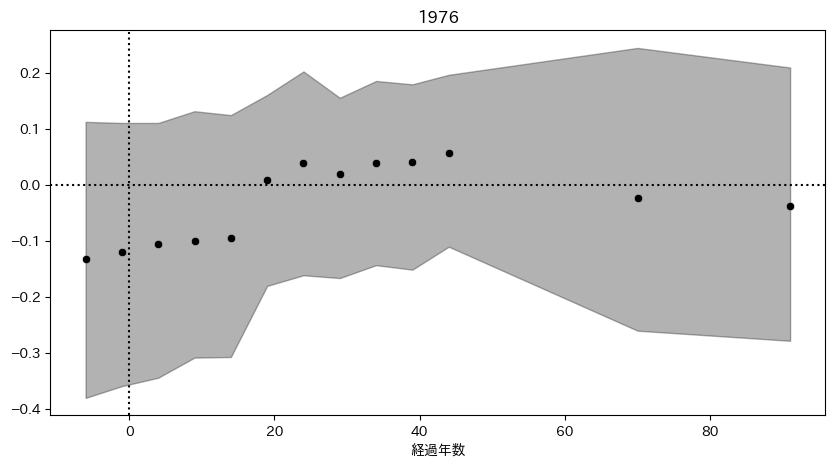

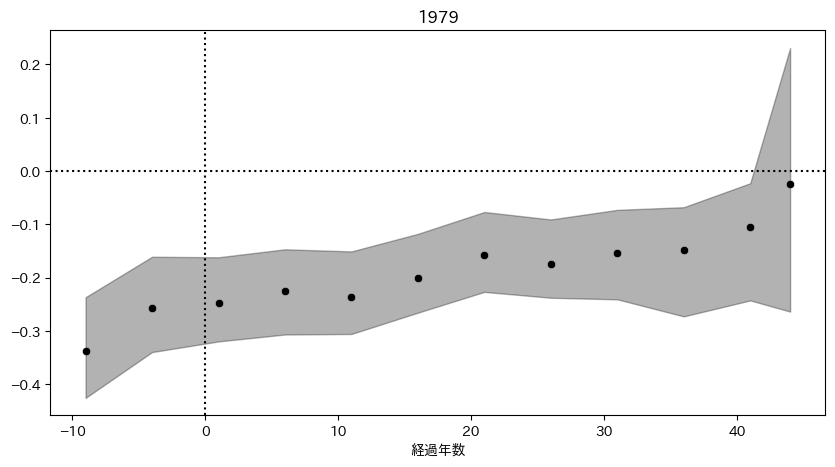

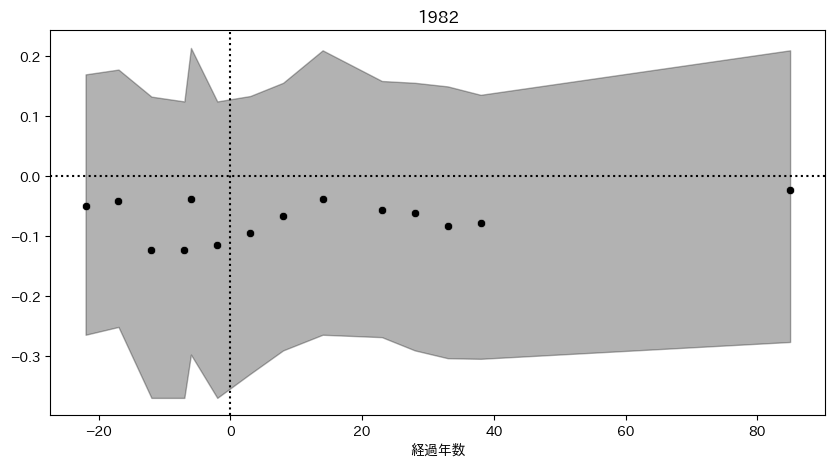

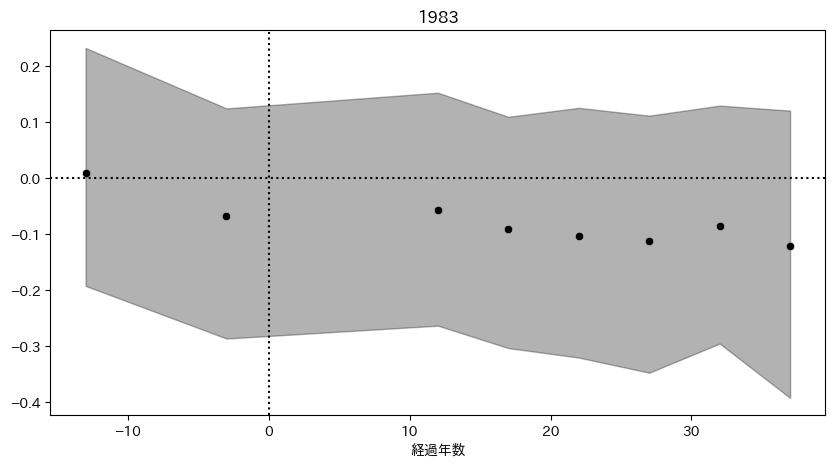

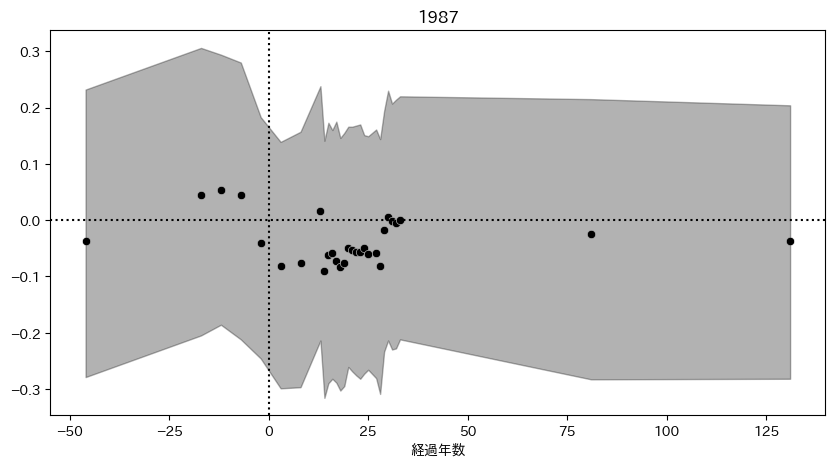

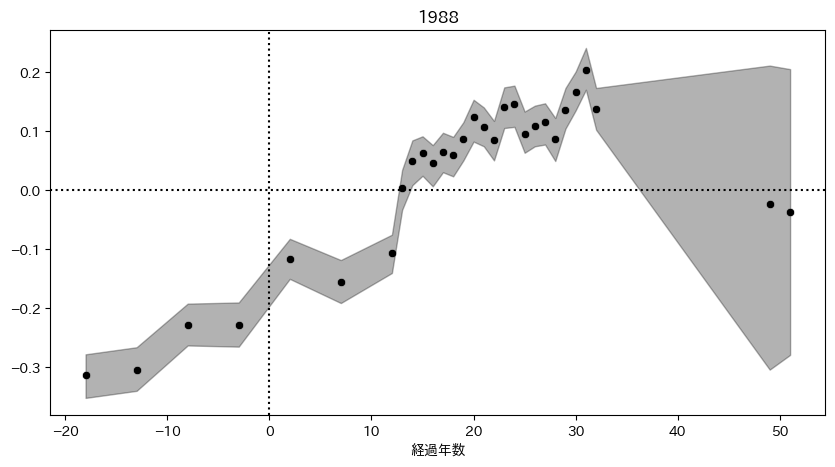

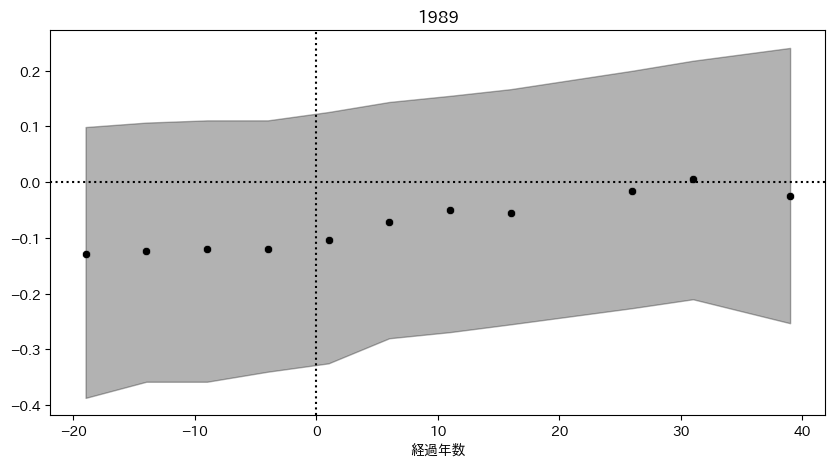

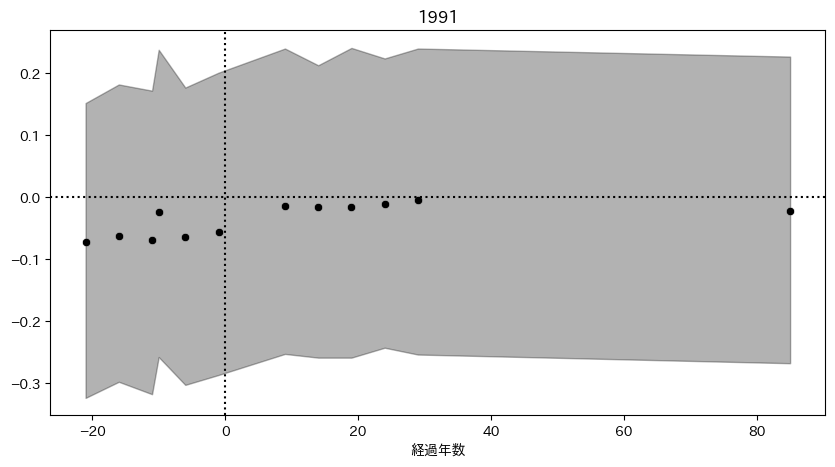

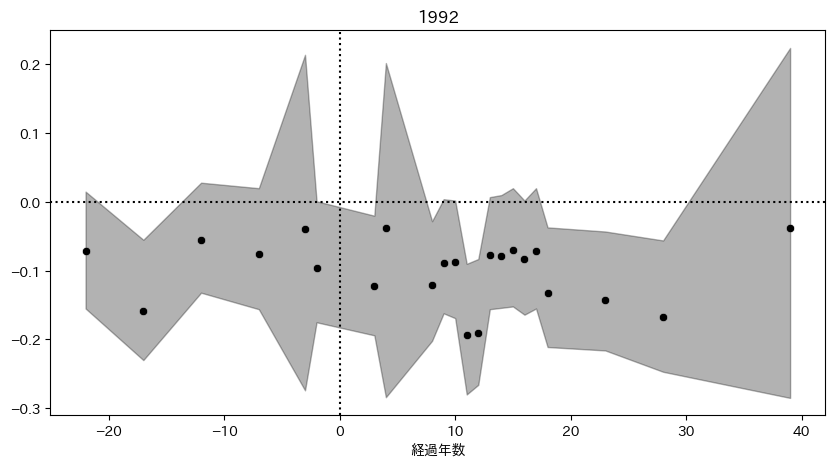

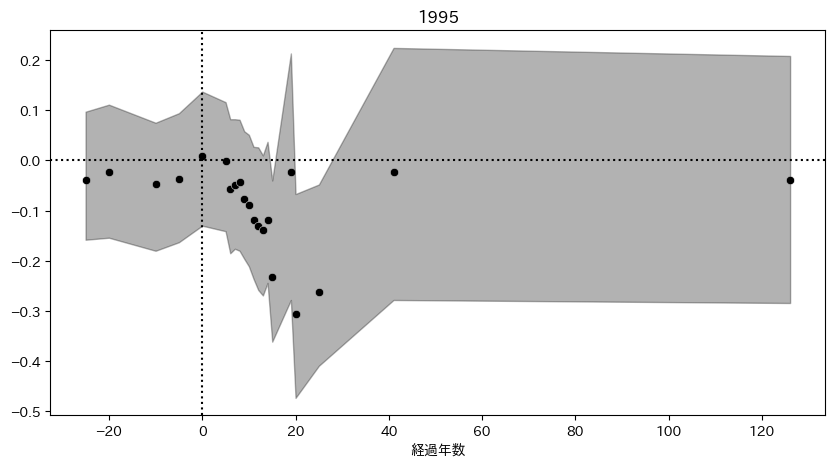

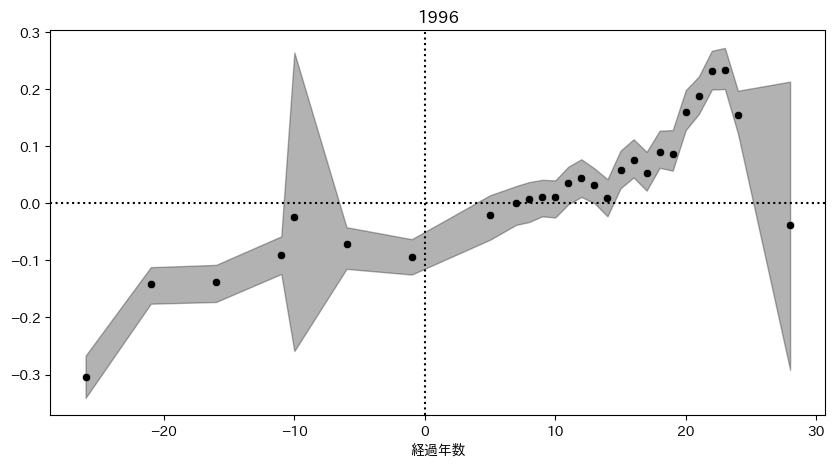

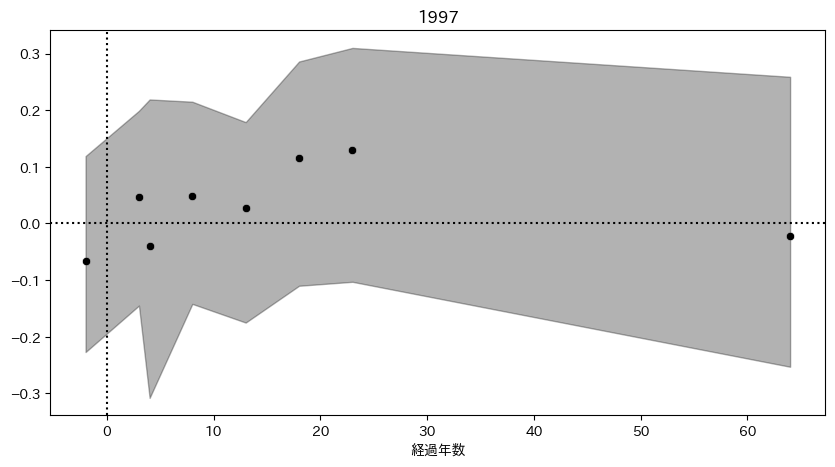

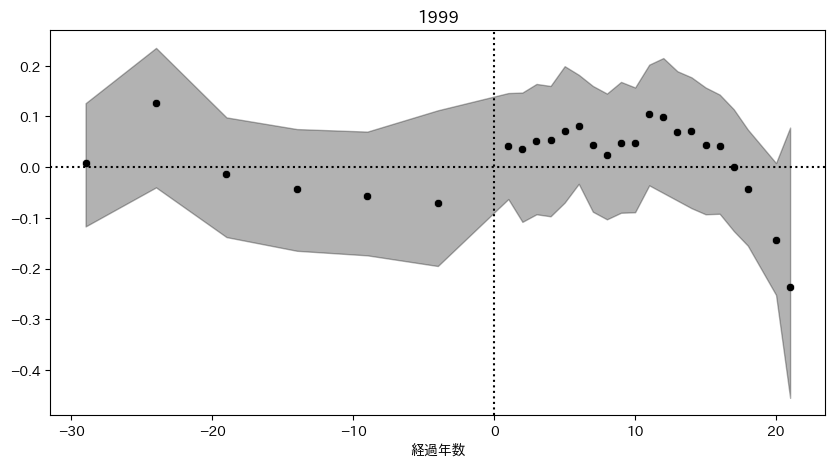

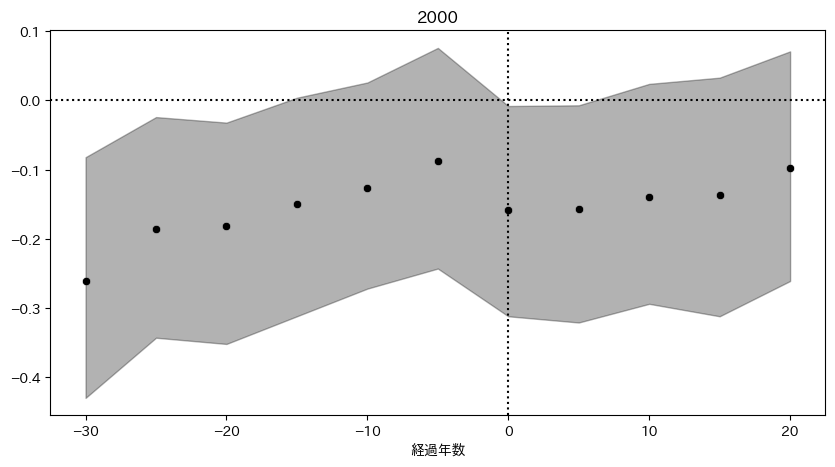

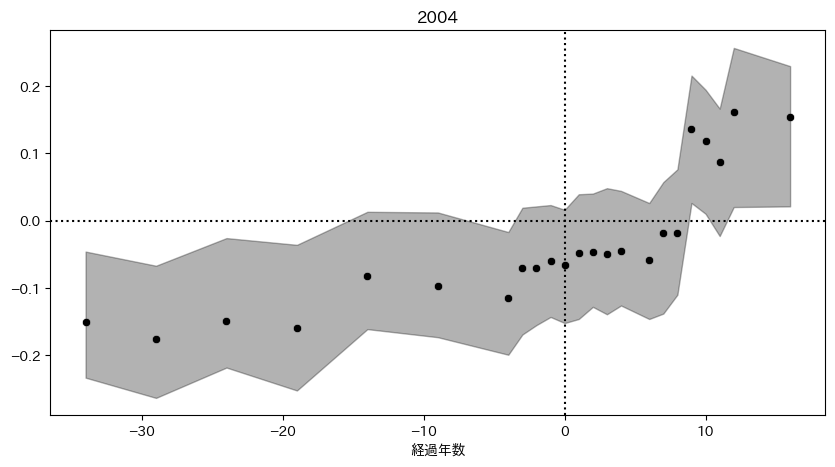

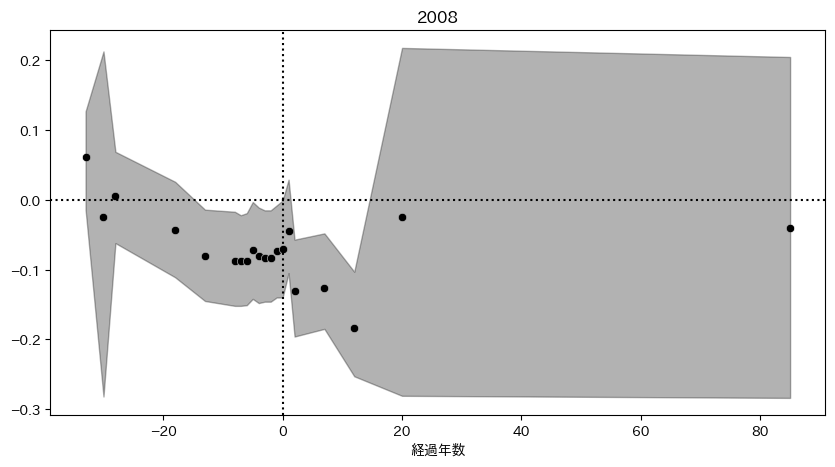

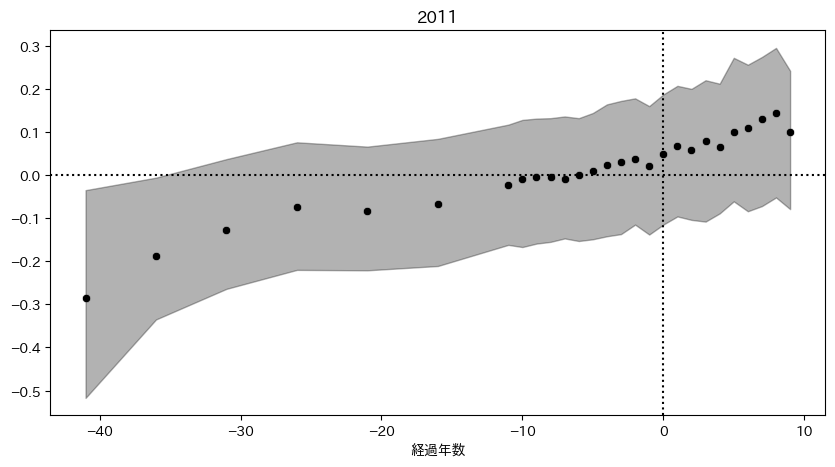

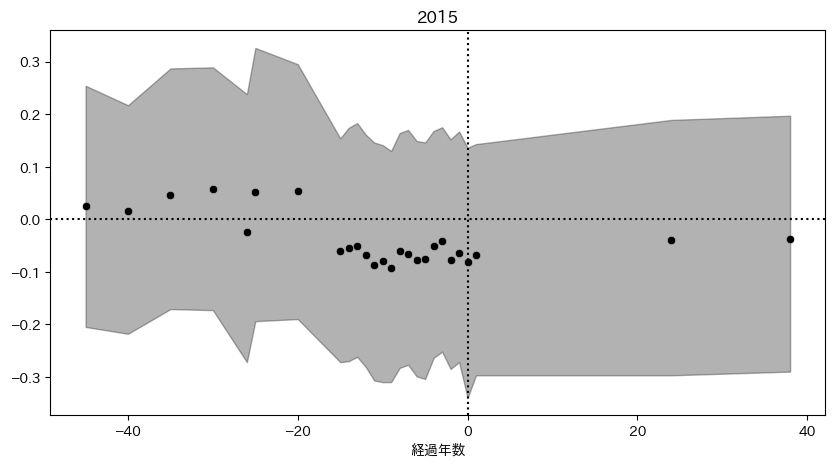

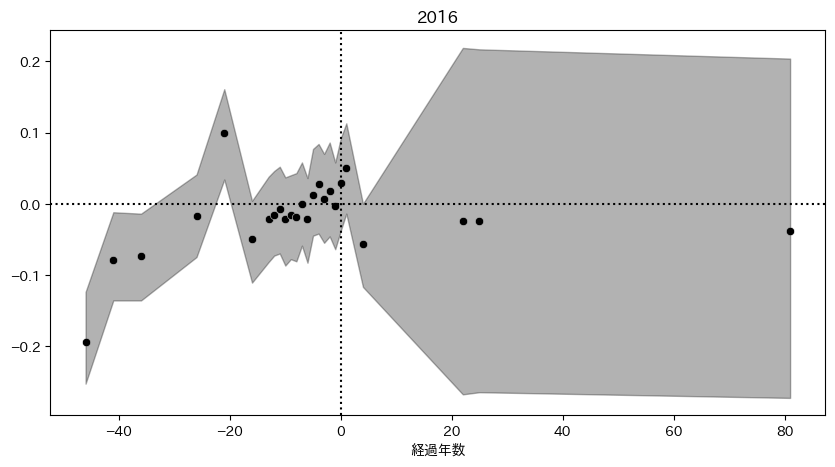

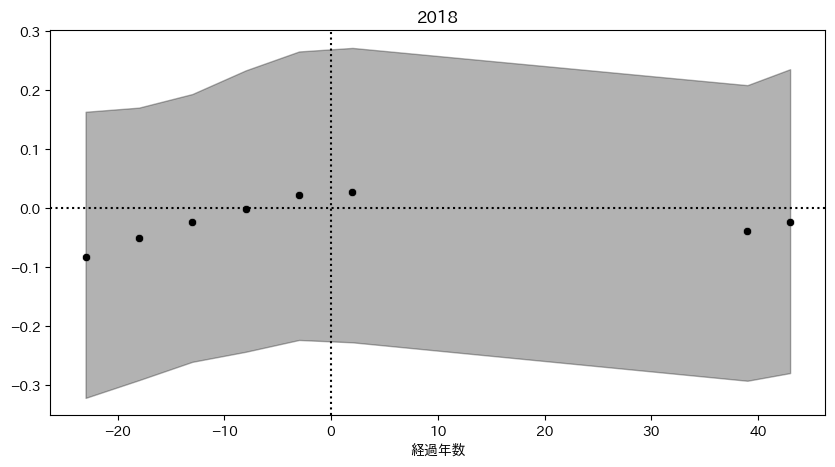

In [103]:
bridge_years = df['bridge_year'].unique()
bridge_years.sort()
for bridge_year in bridge_years:
    beta = FullySaturatedPlotter(df, hetero_beta_df, bridge_year)
    beta.fully_saturated_plot(exclude_same_0=True)

## 均一分散

In [83]:
beta_homo = FullySaturatedPlotter(data=df, beta_df=homo_beta_df)

/tmp/ipykernel_24935/1142279028.py:54: UserWarning: 
The palette list has fewer values (1) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(
/tmp/ipykernel_24935/1142279028.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year_df['year_mean_diff'] = year_df.year_mean.diff()
/tmp/ipykernel_24935/1142279028.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year_df.fillna(0, inplace=True)
/tmp/ipykernel_24935/1142279028.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

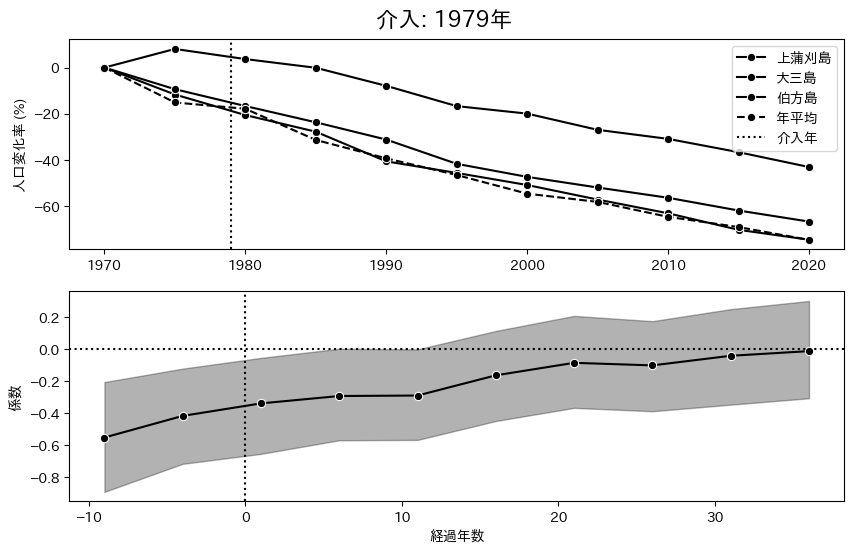

In [85]:
beta_homo.plot_population_and_treatment_effect(bridge_year=1979)

In [51]:
bridge_year_list = df['bridge_year'].unique()
bridge_year_list.sort()

In [52]:
bridge_year_list[1:-1]

array([   0, 1965, 1972, 1973, 1975, 1976, 1979, 1982, 1983, 1987, 1988,
       1989, 1991, 1992, 1995, 1996, 1997, 1999, 2000, 2004, 2008, 2011,
       2015, 2016, 2018])

/tmp/ipykernel_24935/1142279028.py:54: UserWarning: 
The palette list has fewer values (1) than needed (43) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(
/tmp/ipykernel_24935/1142279028.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year_df['year_mean_diff'] = year_df.year_mean.diff()
/tmp/ipykernel_24935/1142279028.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year_df.fillna(0, inplace=True)
/tmp/ipykernel_24935/1142279028.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


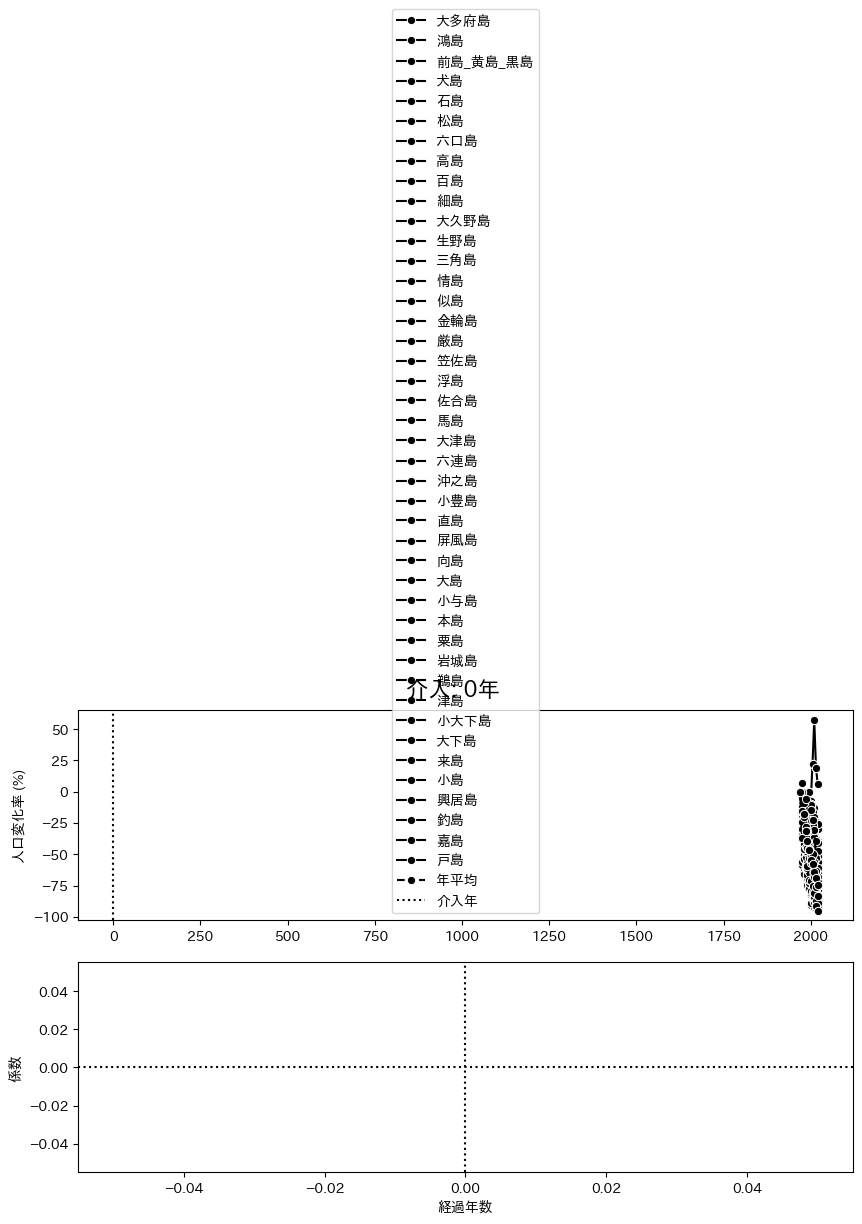

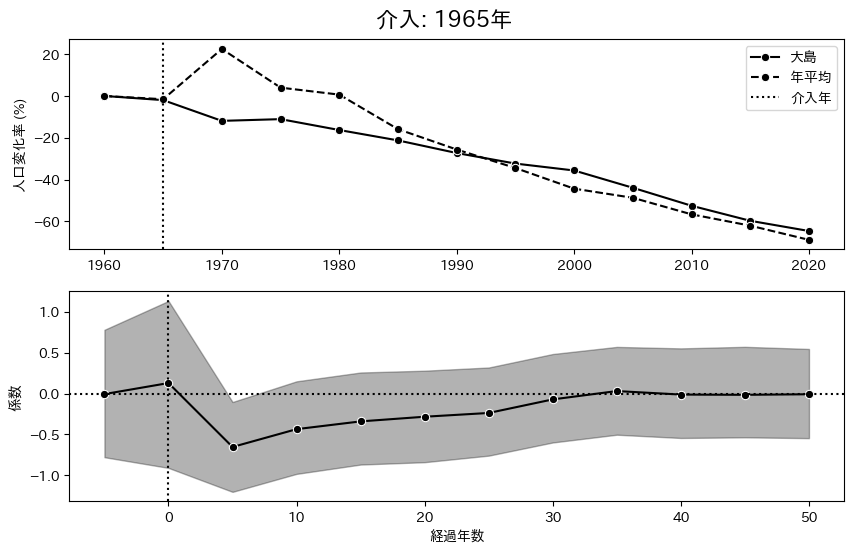

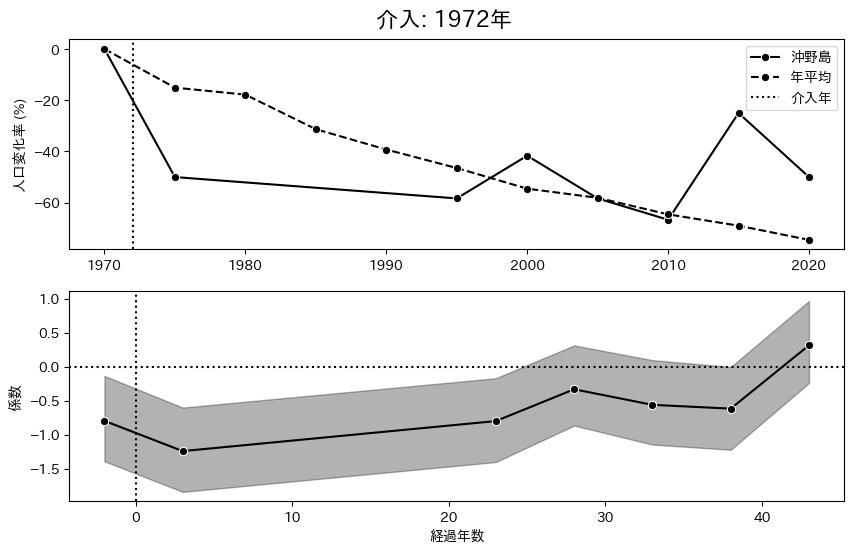

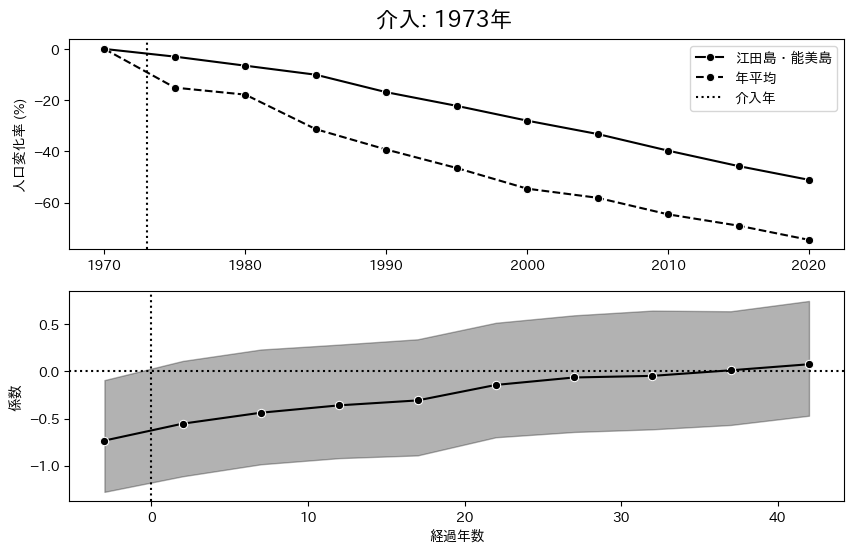

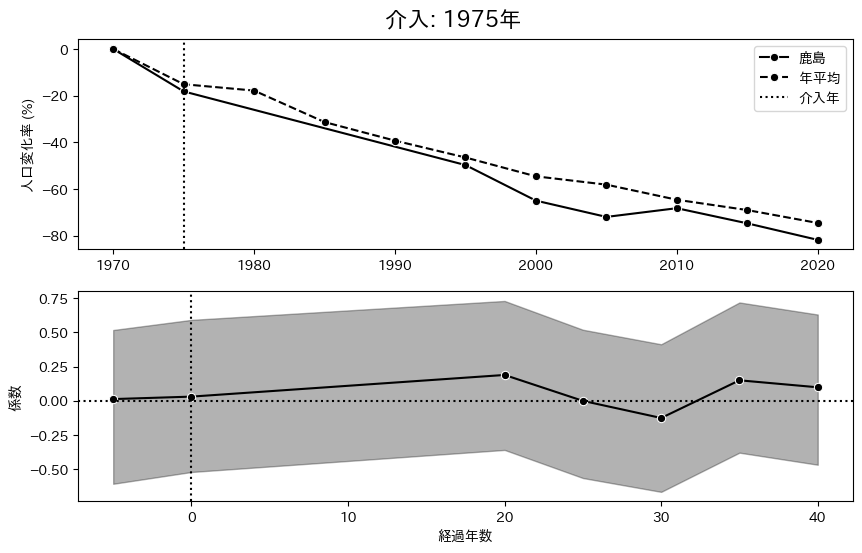

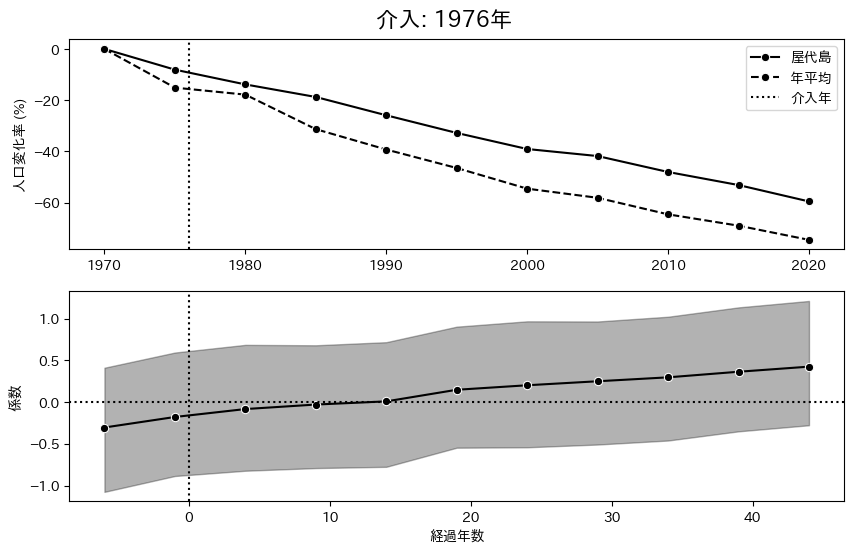

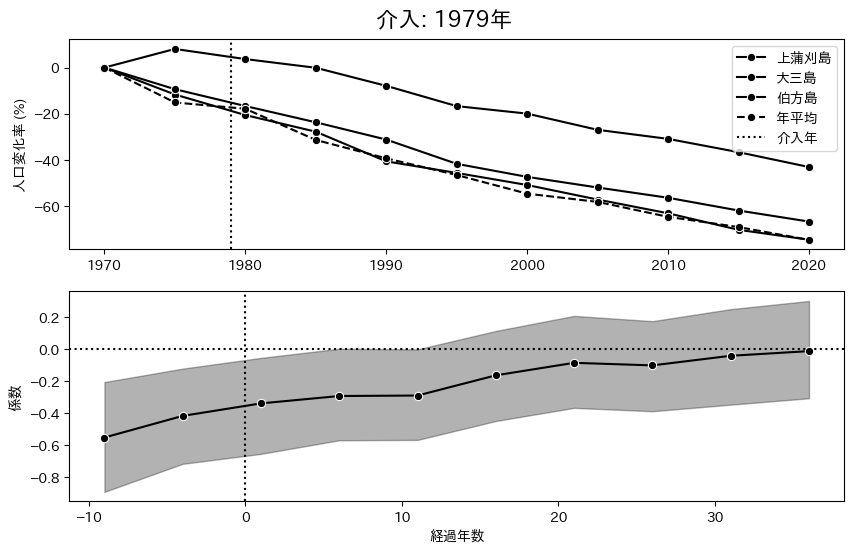

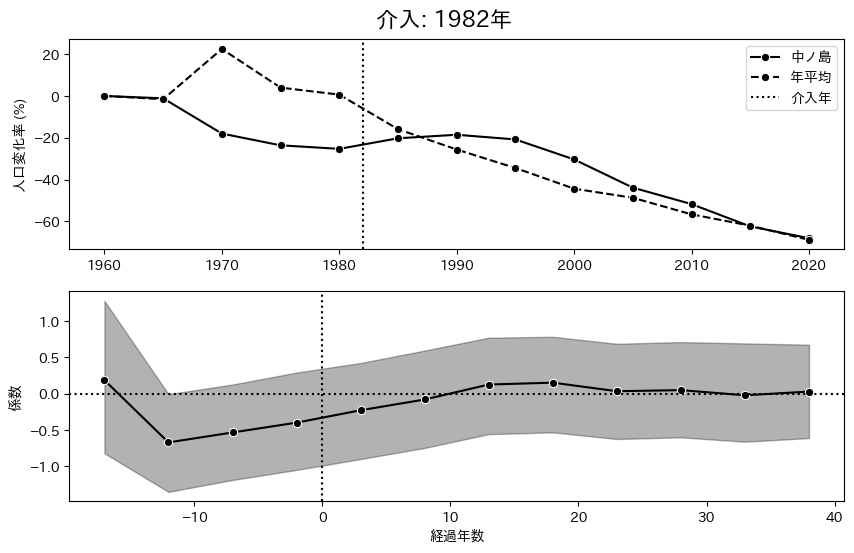

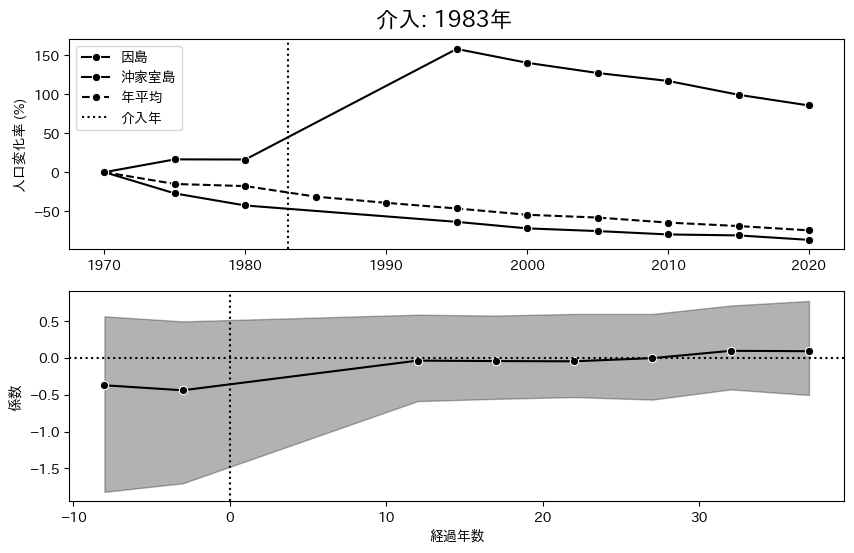

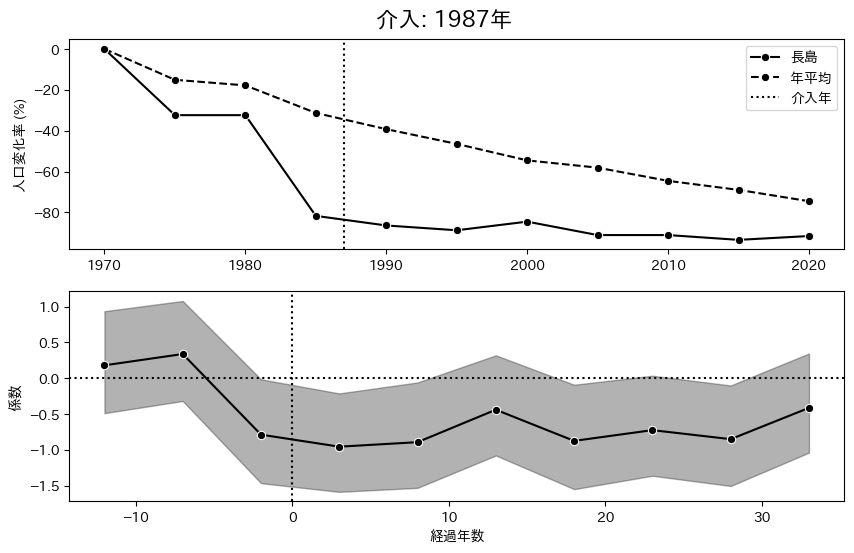

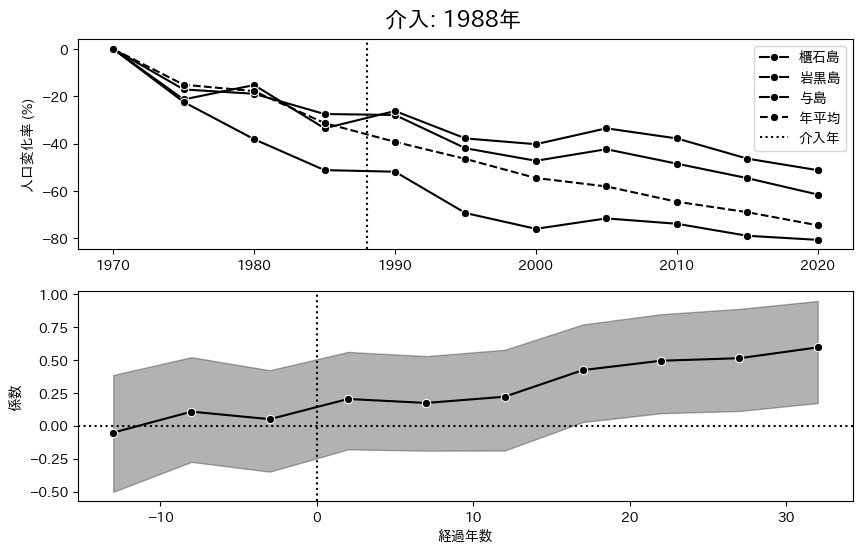

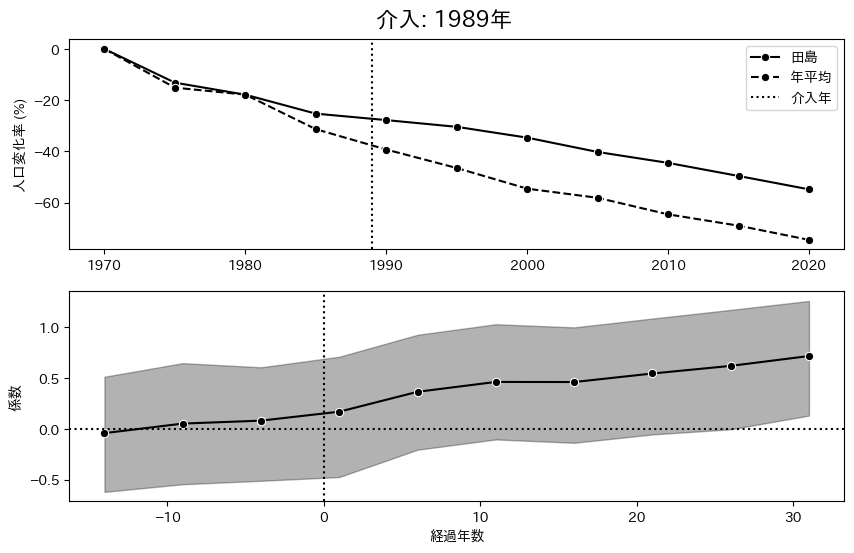

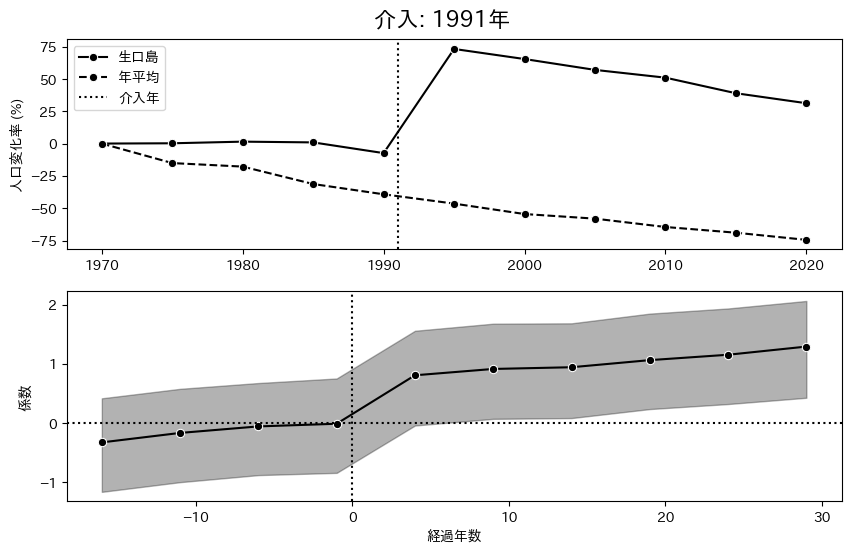

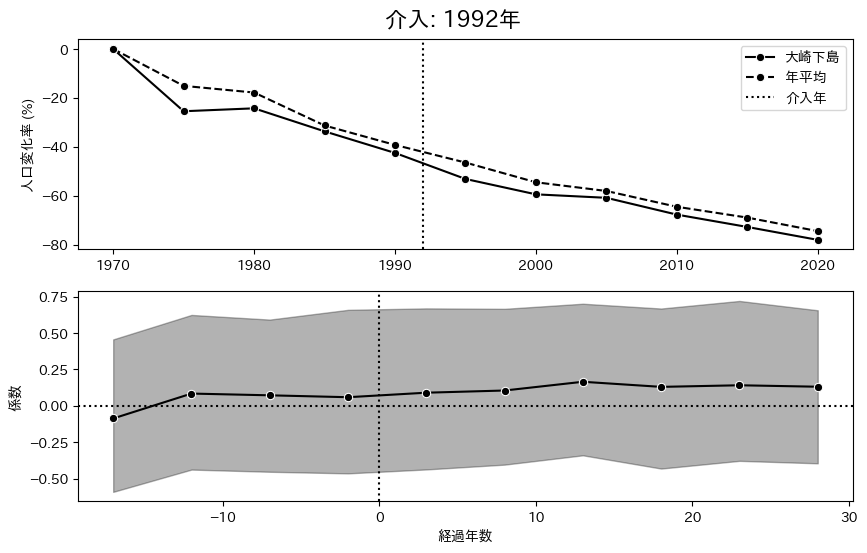

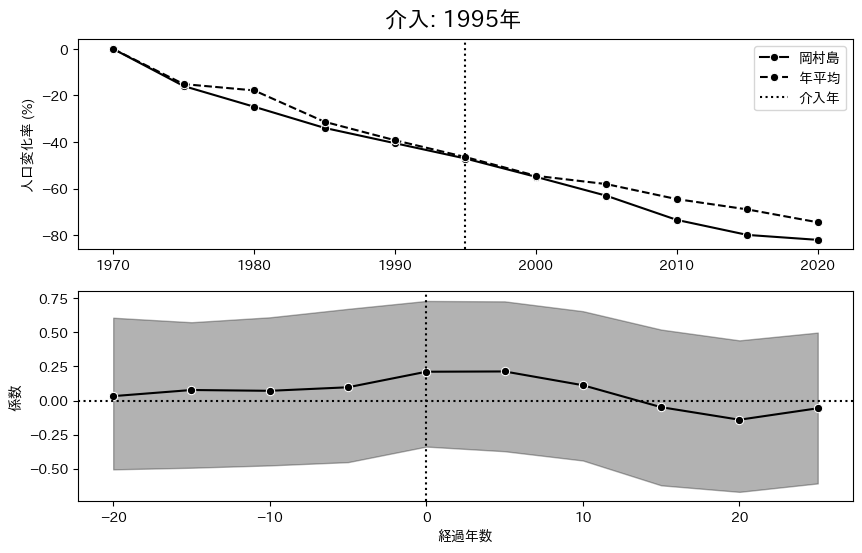

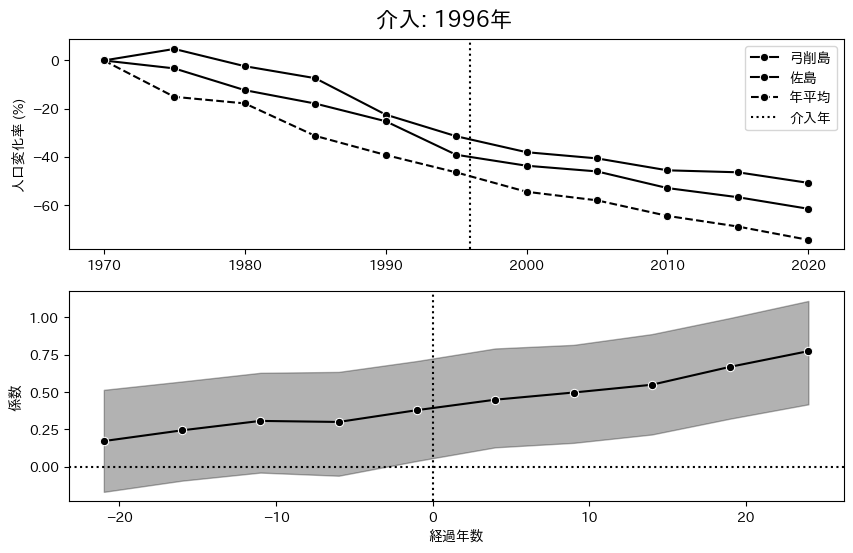

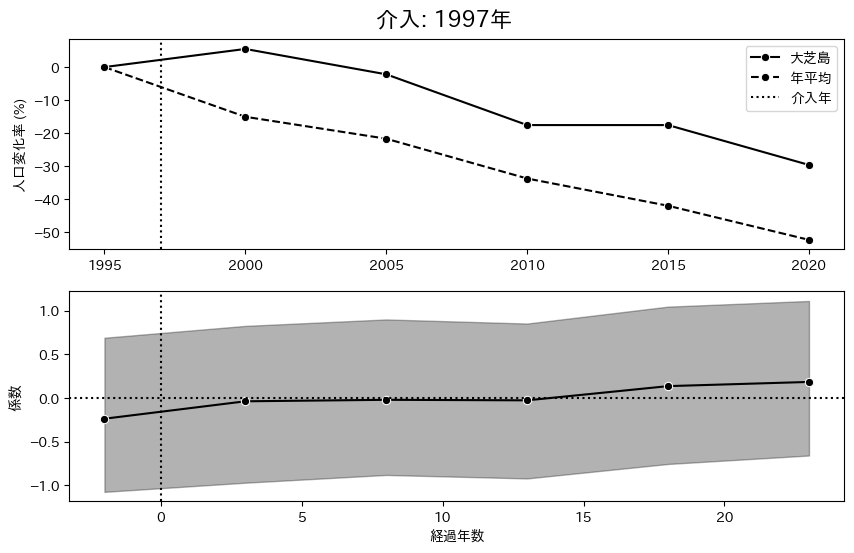

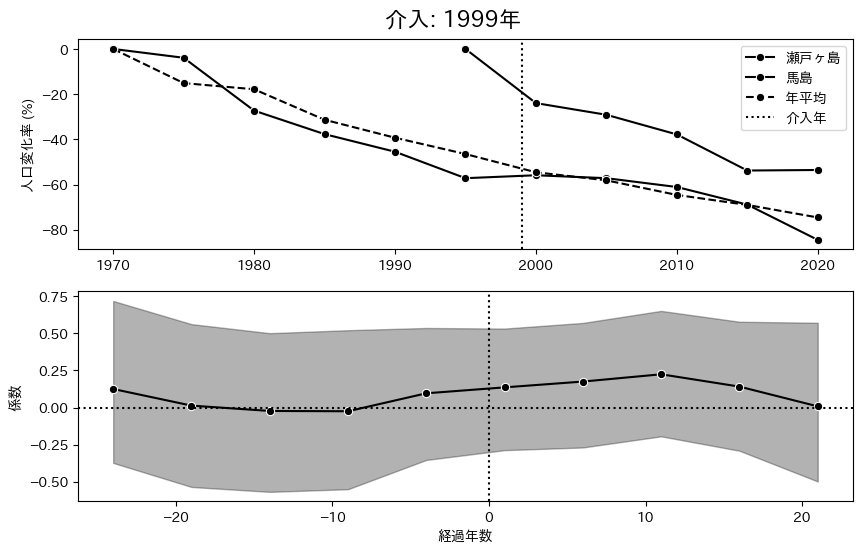

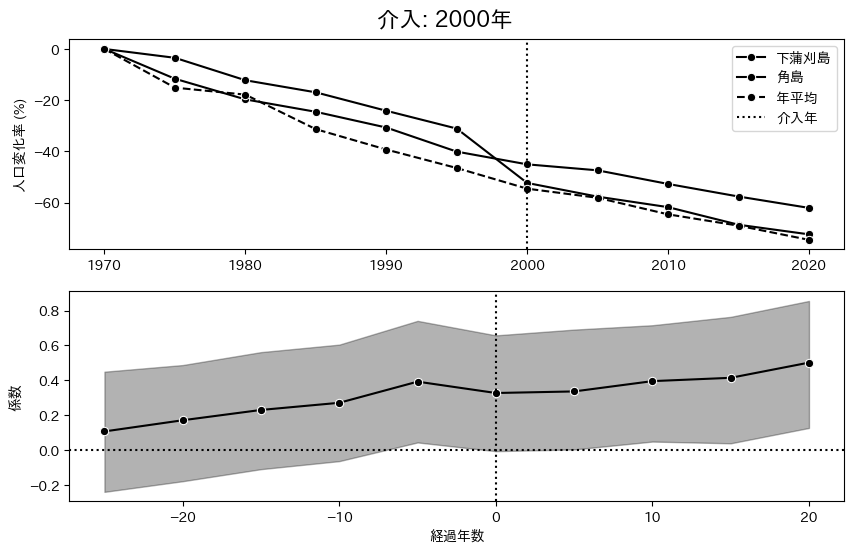

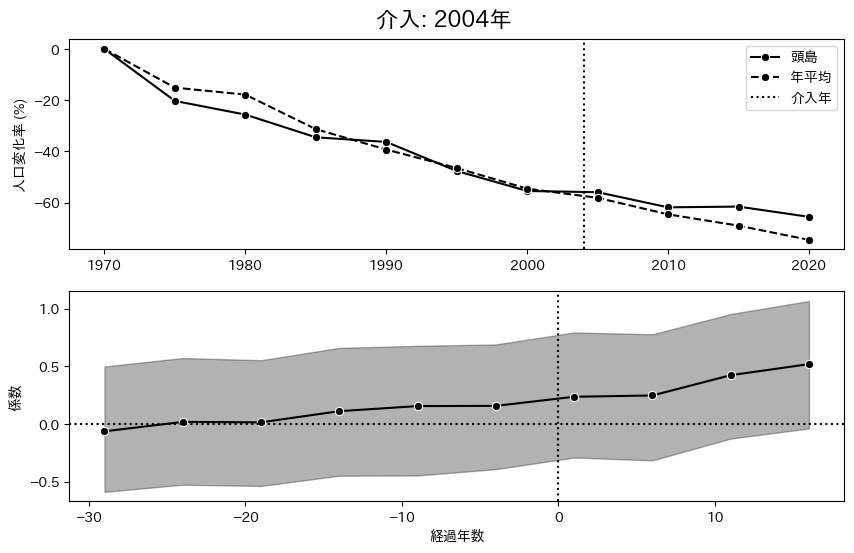

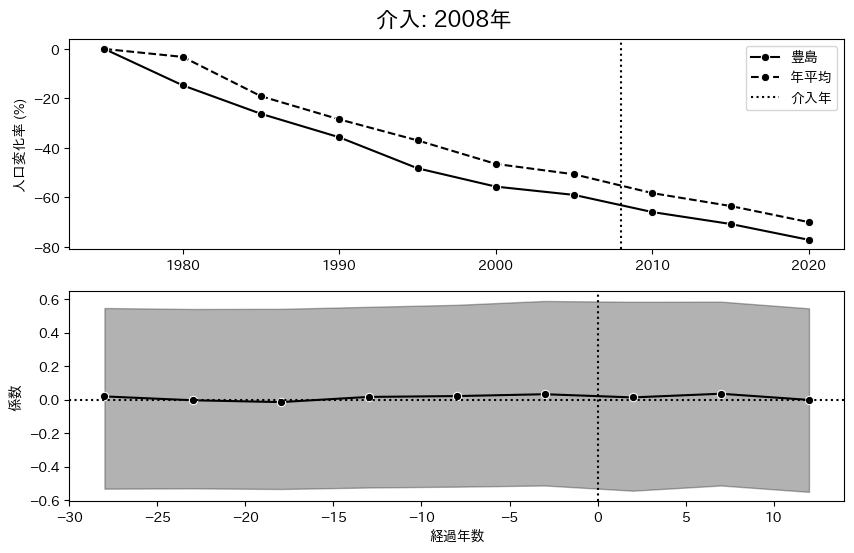

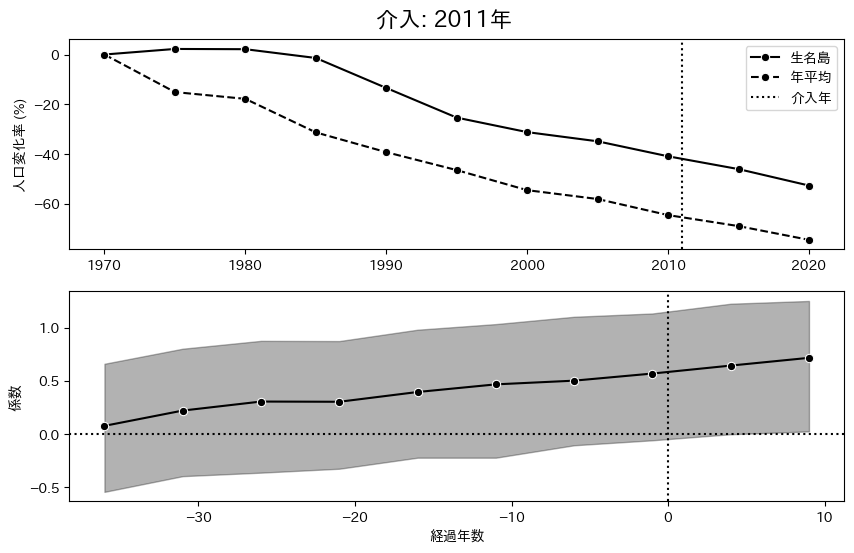

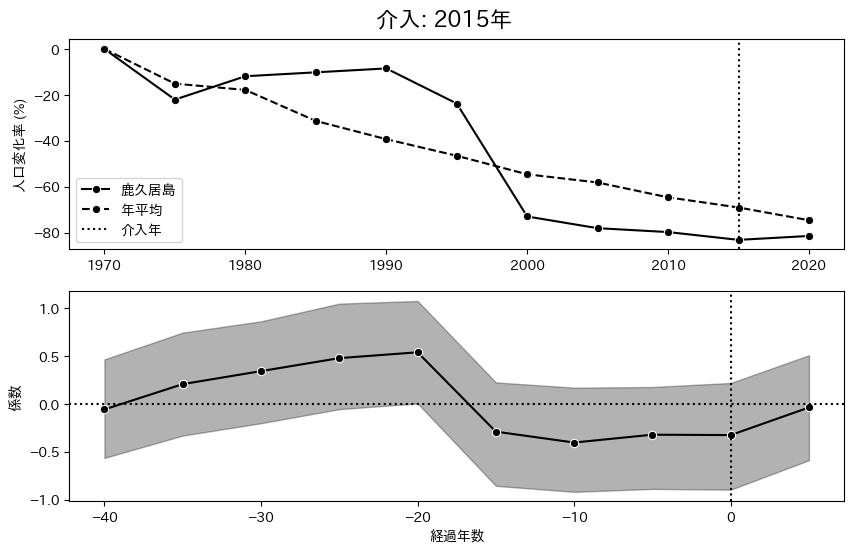

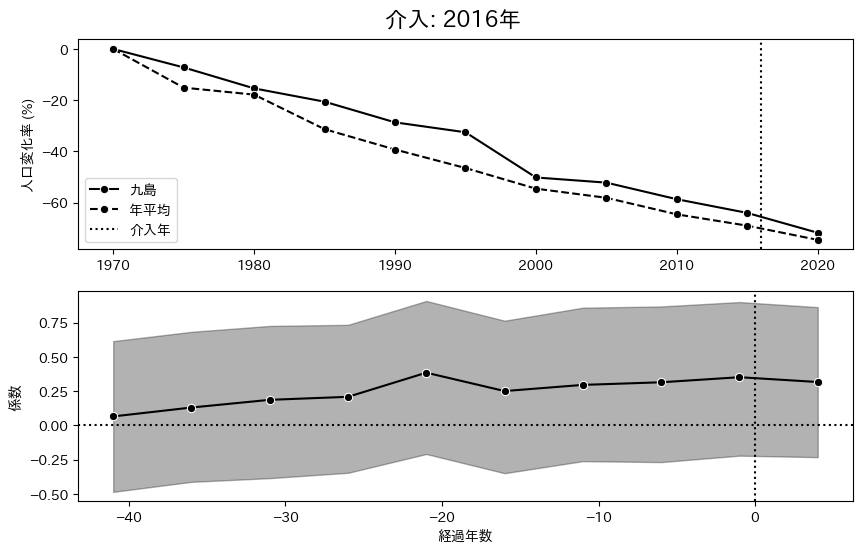

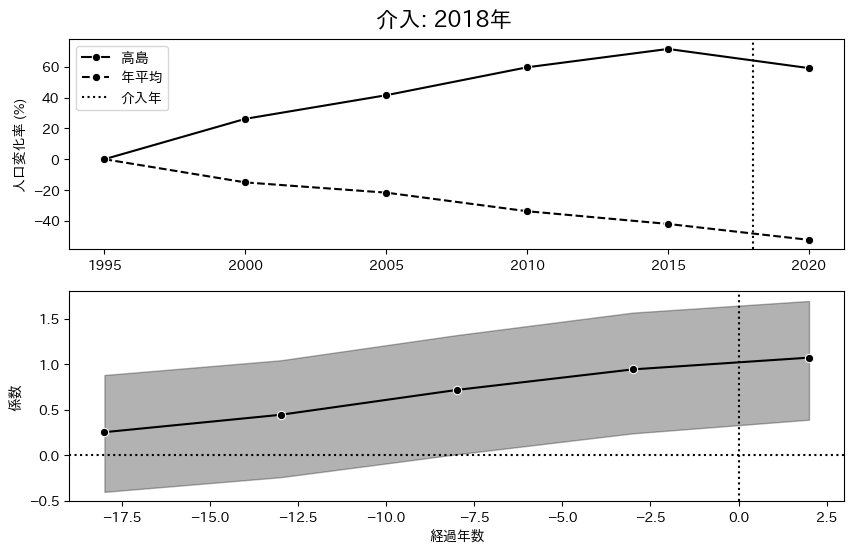

In [86]:
for bridge_year in bridge_year_list:
    beta_homo.plot_population_and_treatment_effect(bridge_year=bridge_year)